# Demonstrating Resolution and Noise Transformations

## Introduction
This notebook is part of the NRTK demonstration suite, demonstrating how perturbations can be applied and their impact measured via MAITE evaluation workflows.

## Layout
This notebook demonstrates how particular sensor transformations (in this case, transformations affecting <b><i>Resolution</i></b> and <b><i>Noise</i></b>), can affect an object detection model, and how that impact can be measured. The overall structure is:

- **Evaluation Guidance: Computing Mean Average Precision (mAP):**
    - An overview of the evaluation strategy.
- **Setup:**
    - Notebook initialization, loading the supporting python code. If this is the first time you've run this notebook, this may take some time.
    - Loading the source image, which will be used throughout the notebook.
- **Image Perturbation Examples:**
    - The NRTK perturbation is demonstrated on the source image.
- **Baseline Detections:**
    - The object detection model is loaded and run on the unperturbed image. These will serve as \"ground truth\" for comparisons against the perturbed images.
 
At this point, we have the fundamental elements of our evaluation: the model, our reference image, and a mechanism for creating the perturbed test images. Next we adapt these elements to be used with the MAITE evaluation workflow:

- **Wrapping the Detection Model**
- **Wrapping the Reference Image as a Dataset**
- **Wrapping the Perturbation as Augmentation Objects**
- **Wrapping the Metrics**

After the evaluation elements have been wrapped, we can run the evaluation:

- **Preparing the Augmentations:**
    - We specify the range of perturbation values to evaluate and optionally specify which ones we'd like to visualize.
- **Evaluation of Augmented Data:**
    - Each augmentation is run through MAITE's evaluation workflow, computing the absolute mAP metric of the detector on the perturbed datasets.
- **Evaluation Analysis:**
    - We plot and discuss the mAP@50 metric from each of the perturbed images, as well as per-class and per-area results.

To run this notebook in Colab, use the link below:

**Note: Running this notebook in Colab requires the v2-8 TPU runtime. To change runtime, go to the Runtime menu -> Change runtime type -> 2-8 TPU**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Kitware/nrtk/blob/main/docs/examples/maite/nrtk_sensor_transformation_demo.ipynb)

## Evaluation Guidance: Computing Mean Average Precision (mAP)

This notebook evaluates the robustness of an Object Detector when exposed to NRTK (Natural, Physics-based) perturbations, using mean Average Precision (mAP) as the performance metric. The baseline case, where no perturbations are applied (identity augmentation), typically yields an mAP close to 1.0 and serves as the reference point. Unlike standard evaluations that focus on whether the detector can correctly identify and localize objects, our goal here is to measure how well the detector maintains its performance under realistic perturbations. 

By comparing the absolute mAP scores of the baseline against perturbed datasets, we can assess the detector's sensitivity to environmental variations and quantify its robustness in generating reliable predictions beyond controlled conditions.

## Setup: Notebook Initialization
The next few cells import the python packages used in the rest of the notebook.

**Note:** We are suppressing warnings within this notebook to reduce visual clutter for demonstration purposes. If any issues arise while executing this notebook, we recommend that the first cell is **not** executed so that any related warnings are shown.

**Note for Colab users**: After setting up the environment, you may need to "Restart Runtime" in order to resolve package version conflicts (see the [README](https://github.com/Kitware/nrtk/blob/main/docs/examples/README.md#run-the-notebooks-from-colab) for more info).

In [1]:
from __future__ import annotations

# warning suppression
import warnings

warnings.filterwarnings("ignore")

In [2]:
print("Beginning package installation...")
%pip install -qU pip

print("Installing nrtk's extras...")
try:
    import albumentations  # noqa: F401 -- intentionally unused, just checking availability
    import cv2  # noqa: F401 -- intentionally unused, just checking availability
    import maite  # noqa: F401 -- intentionally unused, just checking availability

    import nrtk  # noqa: F401 -- intentionally unused, just checking availability
except ImportError:
    %pip install -q "nrtk[maite,albumentations,headless]>=0.25.0"
    pass  # jupytext converts %pip to a comment, so pass keeps the block valid

print("Installing headless OpenCV...")
%pip uninstall -qy opencv-python opencv-python-headless
%pip install -q opencv-python-headless

Beginning package installation...


Note: you may need to restart the kernel to use updated packages.
Installing nrtk's extras...


Installing headless OpenCV...


Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.4.14 requires opencv-python>=4.6.0, which is not installed.
pybsm 0.14.3 requires numpy<2.0,>=1.22; python_version < "3.12", but you have numpy 2.2.6 which is incompatible.
smqtk-classifier 0.20.0 requires numpy<2.0,>=1.23.5; python_version < "3.13", but you have numpy 2.2.6 which is incompatible.
smqtk-dataprovider 0.19.0 requires numpy<2.0,>=1.23.5; python_version < "3.13", but you have numpy 2.2.6 which is incompatible.


Note: you may need to restart the kernel to use updated packages.


In [3]:
print("Installing required packages...")
# Add temporary numpy<2.0 constraint to avoid dependency conflicts
%pip install -q "matplotlib" "torchvision" "torchmetrics" "ultralytics" "numpy<2.0"

Installing required packages...


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.13.0.92 requires numpy>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


Note: you may need to restart the kernel to use updated packages.


In [4]:
# opencv-python depends on libGL, which is unnecessary for running the notebook
# and can cause failures in some environments (e.g., GitLab CI). To avoid this,
# we uninstall all opencv variants and install opencv-python-headless instead.

# OpenCV must be uninstalled and reinstalled last due to other packages installing OpenCV
# Add temporary numpy<2.0 constraint to avoid dependency conflicts
print("Doing a fresh install of opencv-python-headless...")
%pip uninstall -qy "opencv-python" "opencv-python-headless"
%pip install -q "opencv-python-headless" "numpy<2.0" --no-cache-dir

Doing a fresh install of opencv-python-headless...


Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import urllib.request
from collections.abc import Sequence
from typing import Any

import numpy as np

# some initial imports
%matplotlib inline
%config InlineBackend.figure_format = "jpeg"  # Use JPEG format for inline visualizations

from matplotlib import pyplot as plt
from PIL import Image

from nrtk.impls.perturb_image.optical import PybsmPerturber
from nrtk.utils._extras import print_extras_status

print_extras_status()

Detected status of NRTK extras and their dependencies:



[albumentations]
  - nrtk-albumentations       ✓ unknown

[diffusion]
  - torch                     ✓ 2.10.0+cu128
  - diffusers                 ✓ 0.36.0
  - accelerate                ✓ 1.12.0
  - Pillow                    ✓ 12.1.1
  - transformers              ✓ 5.1.0
  - protobuf                  ✗ missing

[graphics]
  - opencv-python             ✗ missing

[headless]
  - opencv-python-headless    ✓ 4.11.0

[maite]
  - maite                     ✓ 0.9.2

[pillow]
  - Pillow                    ✓ 12.1.1

[pybsm]
  - pybsm                     ✓ 0.14.3

[skimage]
  - scikit-image              ✗ missing

[tools]
  - kwcoco                    ✗ missing
  - Pillow                    ✓ 12.1.1
  - click                     ✓ 8.3.1
  - fastapi                   ✗ missing
  - uvicorn                   ✗ missing
  - pydantic                  ✓ 2.12.5
  - pydantic-settings         ✗ missing
  - python-json-logger        ✗ missing

[waterdroplet]
  - scipy                     ✓ 1.15.3
  - numba   

    https://nrtk.readthedocs.io/en/v0.26.0/installation.html#extras



## Setup: Source Image

In the next cell, we'll download and display a source image from the __[VisDrone](https://github.com/VisDrone/VisDrone-Dataset)__ dataset. The image will be cached in a local `data` subdirectory.

### A Note on Image Storage

Typically in ML workflows, batches of images are processed as tensors of the color channels. Both our perturber (NRTK) and object detector (YOLO) accept numpy `ndarray` objects, and we will use [matplotlib.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) to view them. The complication is that YOLO [expects the color channels to be in BGR](https://docs.ultralytics.com/modes/predict/) order. If we naively view the same data YOLO inferences on, the colors will be wrong; if we naively inference on what we view, the detections will be wrong. (Our NRTK perturbation is agnostic to the channel order.)

In this notebook, we'll convert the channel order to BGR when we load, and convert back whenever we explicitly call `imshow`.


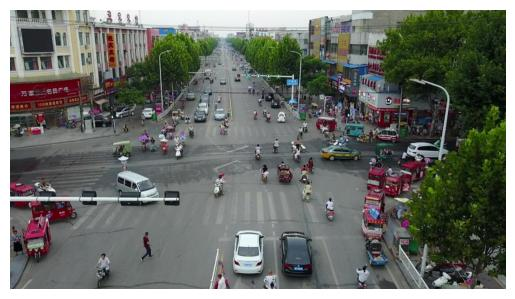

In [6]:
data_dir = "./data"
os.makedirs(data_dir, exist_ok=True)
img_path = os.path.join(data_dir, "visdrone_img.jpg")
if not os.path.isfile(img_path):
    url = "https://data.kitware.com/api/v1/item/623880f14acac99f429fe3ca/download"
    _ = urllib.request.urlretrieve(url, img_path)  # noqa: S310

img_pil = Image.open(img_path)
img_nd_bgr = np.asarray(img_pil)[
    :,
    :,
    ::-1,
]  # tip o' the hat to https://stackoverflow.com/questions/4661557/pil-rotate-image-colors-bgr-rgb
plt.figure()
plt.axis("off")

_ = plt.imshow(img_nd_bgr[:, :, ::-1])  # explicitly changing BGR to RGB for imshow

## NRTK Sensor Transformation Perturbation: Examples and Guidance

This notebook uses the [PybsmPerturber](<project:/reference/api/_implementations/nrtk.impls.perturb_image.optical.PybsmPerturber.rst>) to perform a sensor transformation perturbation. The `PybsmPerturber` takes in all relevant sensor parameters needed to simulate an image captured using that sensor.

### Setup

We begin the setup for these sensor transformation perturbations by creating a dictionary of sensor and scenario parameters. These represent the parameters of the sensor used to capture the original image and the conditions that were present to faithfully create an identity transformation. Since we do not know the exact parameters of the sensor that we are trying to model, we use the `estimate_capture_parameters` function to approximate reasonable values for the sensor parameters based on the estimated `gsd` and `altitude` of the image.

We can estimate the gsd (meters/pixel) by taking the average height of people (~1.7 meters) and dividing it by the average height of the person detections in the image. We then estimate the altitude of the drone used to capture the VisDrone images, and use that value as input to the `estimate_capture_parameters` function.

For additional information on how these parameters affect image formation, see this [pyBSM explanation](https://pybsm.readthedocs.io/en/latest/explanation.html).
  

In [7]:
from pybsm.simulation.ref_image import RefImage

gsd = 1.7 / 58  # average height of person in meters divided by average height of person detection in pixels

ref_img = RefImage(img=img_nd_bgr, gsd=gsd)
sensor, scenario = ref_img.estimate_capture_parameters(altitude=75)

pybsm_sensor_config = {
    # required
    "sensor_name": "ideal_sensor",
    "D": sensor.D,  # Telescope diameter (m)
    "f": sensor.f,  # telescope focal length (m)
    "p_x": sensor.p_x,  # detector pitch (m)
    "opt_trans_wavelengths": sensor.opt_trans_wavelengths,  # Optical system transmission, red  band first (m)
    # optional
    "optics_transmission": sensor.optics_transmission,  # guess at the full system optical transmission
    # (excluding obscuration)
    "eta": sensor.eta,  # guess
    "w_x": sensor.p_x,  # detector width is assumed to be equal to the pitch
    "w_y": sensor.p_x,  # detector width is assumed to be equal to the pitch
    "int_time": sensor.int_time,  # integration time (s) - this is a maximum, the actual integration time will be,
    # determined by the well fill percentage
    "dark_current": sensor.dark_current,  # dark current density of 1 nA/cm2 guess, guess mid
    # range for a silicon camera
    "read_noise": sensor.read_noise,  # rms read noise (rms electrons)
    "max_n": sensor.max_n,  # maximum ADC level (electrons)
    "bit_depth": sensor.bit_depth,  # bit depth
    "max_well_fill": sensor.max_well_fill,  # maximum allowable well fill (see the paper for the logic behind this)
    "s_x": sensor.s_x,  # jitter (radians) - The Olson paper says its "good" so we'll guess 1/4 ifov rms
    "s_y": sensor.s_y,  # jitter (radians) - The Olson paper says its "good" so we'll guess 1/4 ifov rms
    "qe_wavelengths": sensor.qe_wavelengths,
    "qe": sensor.qe,
}

pybsm_scenario_config = {
    "scenario_name": "niceday",
    "ihaze": scenario.ihaze,  # weather model
    "altitude": scenario.altitude,  # sensor altitude
    "ground_range": scenario.ground_range,  # range to target
    "aircraft_speed": scenario.aircraft_speed,
}

pybsm_config = pybsm_sensor_config | pybsm_scenario_config

### Resolution Transformation

 The first is a change in resolution of the image. We will change the resolution by modifying the pixel width parameters `p_x` and `p_y`. For the purpose of this example notebook we will keep the pixels as squares by ensuring `p_x` and `p_y` are the same.

Changing the value of `p_x` and `p_y` will have the following effects:

- `p_x != 0.0`: This would result in an infinitely small pixel. The value of 0 is out of bounds
- `0.0 < p_x < min(height, width)`: allowable pixel heights and widths. As the pixel size gets larger, it will result in a lower resolution as each pixel is responsible for representing a greater area 

In reality the minimum pixel size is the one used to capture the original image as pybsm and nrtk only support image degradation, not image super resolution.

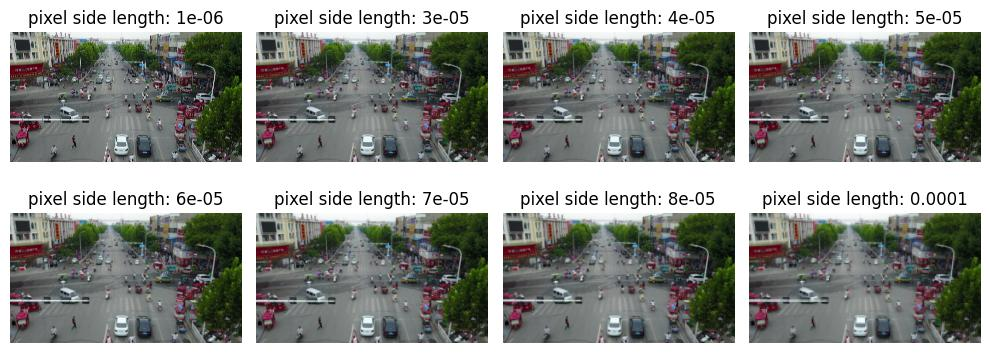

In [8]:
import copy

_, ax = plt.subplots(2, 4, figsize=(10, 4))
pybsm_config_copy = copy.deepcopy(pybsm_config)
for idx, f in enumerate((1e-06, 3e-05, 4e-05, 5e-05, 6e-05, 7e-05, 8e-05, 1e-04)):
    (row, col) = (int(idx / 4), idx % 4)
    pybsm_config_copy["p_x"] = f
    pybsm_config_copy["p_y"] = f
    perturber = PybsmPerturber(**pybsm_config_copy)
    img = perturber(image=img_nd_bgr, img_gsd=gsd)[0][:, :, ::-1]
    ax[row, col].set_title(f"pixel side length: {f}")
    ax[row, col].imshow(img)
    _ = ax[row, col].axis("off")
plt.tight_layout()

### Noise Transformation

The second transformation that we will be exploring is a change in the noise in the image. The parameter that we will be modifying to accomplish this is the `bit_depth` parameter. This parameter represents the number of bits available to represent each pixel's value.

An example of where this use case might come into practice is if a model was trained on imagery captured from a model with a bit depth of 16 bits, but needs to be deployed on a low power sensor that only has 4 bits available. 

The minimum `bit_depth` is `1`. There is no official upper limit to the `bit_depth`, but it would be very rare to encounter a value higher than `16`

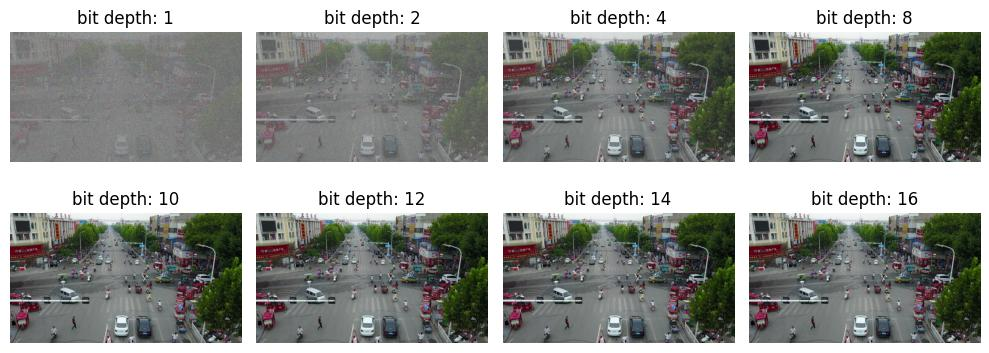

In [9]:
_, ax = plt.subplots(2, 4, figsize=(10, 4))
pybsm_config_copy = copy.deepcopy(pybsm_config)
for idx, bd in enumerate((1, 2, 4, 8, 10, 12, 14, 16)):
    (row, col) = (int(idx / 4), idx % 4)
    pybsm_config_copy["bit_depth"] = bd
    perturber = PybsmPerturber(**pybsm_config_copy)
    img = perturber(image=img_nd_bgr, img_gsd=gsd)[0][:, :, ::-1]
    ax[row, col].set_title(f"bit depth: {bd}")
    ax[row, col].imshow(img)
    _ = ax[row, col].axis("off")
plt.tight_layout()

## Baseline Detections

In the next cell, we'll download a [YOLOv11](https://docs.ultralytics.com/models/yolo11/) model, compute object detections on the source image, and display the results. As discussed above, these detections will serve as the "ground truth" for our mAP evaluation later.

*Note that here, we're using YOLO's built-in visualization tool, which automatically adjusts for BGR / RGB order.*

In [10]:
# Import YOLO support
import torch
import ultralytics

ultralytics.checks()
print("Downloading model...")
model = ultralytics.YOLO("yolo11n.pt")
print("Computing baseline...")
baseline = model(img_nd_bgr)

Ultralytics 8.4.14 🚀 Python-3.10.12 torch-2.10.0+cu128 CPU (12th Gen Intel Core(TM) i9-12900H)


Setup complete ✅ (20 CPUs, 62.5 GB RAM, 654.5/914.7 GB disk)


Computing baseline...



0: 384x640 5 persons, 15 cars, 1 motorcycle, 2 trucks, 37.1ms


Speed: 3.2ms preprocess, 37.1ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


## MAITE Evaluation Workflow Preparation

We'll use the [MAITE Evaluation workflow](https://github.com/mit-ll-ai-technology/maite/blob/687706bf48efb9366aca5b9d588bafe2f460e644/src/maite/_internals/tasks/generic.py#L190) to evaluate the performance of the perturbed data against our baseline detections. We'll need to "wrap" our model, data, and perturbations into callable objects to pass to the `maite.tasks.evaluate` function:

- We'll wrap the **model** to make predictions on input data when called.

- The wrapped **dataset** will return our test image when called. Note that this will be the original, unperturbed image; we'll apply our perturbations via the **augmentation** object, which applies the perturbation to the image inside the evaluation.

- Finally, the **metric** object will define our precise scoring methodology.

The evaluation workflow in this notebook is slightly unusual. Typical ML workflows apply many different augmentations / perturbations to much larger datasets, and only call `evaluate` once to get a statistical view of performance. Since the goal of this notebook is to drill down into how perturbation affects performance, we've essentially flipped the process, calling `evaluate` (and thus our wrapped objects) many times, once per loop on our single image perturbed to a known degree, and then observing how the metrics respond.

### Some Helper Classes

The following cell adds two classes to allow us to use YOLO detections with the MAITE evaluation workflow:

1. The `YOLODetectionTarget` helper class that stores the bounding boxes, label indices, and confidence scores for a single image's detections.

2. The `MaiteYOLODetection` adapter class that conforms to the MAITE [Object Detection Dataset](https://github.com/mit-ll-ai-technology/maite/blob/687706bf48efb9366aca5b9d588bafe2f460e644/src/maite/_internals/protocols/object_detection.py#L86) protocol by providing the `__len__` and `__getitem__` methods. The returned item is a tuple of (image, `YOLODetectionTarget`, metadata-dictionary).

In [11]:
from dataclasses import dataclass

from maite.protocols.object_detection import DatumMetadataType

from nrtk.interop._maite.datasets import MAITEObjectDetectionDataset

##
## Helper class for containing the boxes, label indices, and confidence scores.
##


@dataclass
class DetectionDatumMetadata(DatumMetadataType):
    """Dataclass for detection datum-level metadata."""

    id: int | str
    img_gsd: float


@dataclass
class YOLODetectionTarget:
    """A helper class to represent object detection results in the format expected by YOLO-based models.

    Attributes:
        boxes (torch.Tensor): A tensor containing the bounding boxes for detected objects in
            [x_min, y_min, x_max, y_max] format.
        labels (torch.Tensor): A tensor containing the class labels for the detected objects.
            These may be floats for compatibility with specific datasets or tools.
        scores (torch.Tensor): A tensor containing the confidence scores for the detected objects.
    """

    boxes: torch.Tensor
    labels: torch.Tensor
    scores: torch.Tensor


##
## Prepare results for ingestion into maite dataset by puttin them into detection object
## Images must be channel first (c, h, w) in maite dataset objects
##
imgs = [np.transpose(img_nd_bgr, (2, 0, 1))]
dets = []
metadata: list[DetectionDatumMetadata] = [{"id": 0, "img_gsd": gsd}]
for _detection in baseline:
    boxes = baseline[0].boxes.xyxy.cpu()
    labels = baseline[0].boxes.cls.cpu()  # note, these are floats, not ints
    scores = baseline[0].boxes.conf.cpu()

    dets.append(YOLODetectionTarget(boxes, labels, scores))

### (1) Wrapping the Detection Model

The first object we'll wrap will be the detection model. The cell below defines a class adapting YOLO for the [MAITE Object Detection Model](https://github.com/mit-ll-ai-technology/maite/blob/687706bf48efb9366aca5b9d588bafe2f460e644/src/maite/_internals/protocols/object_detection.py#L376) protocol. The `__call__` method runs the model on images in the batch and is called by the MAITE evaluation workflow later in the notebook.

In [12]:
import maite.protocols.object_detection as od
import ultralytics.models
from maite.protocols import ArrayLike, ModelMetadata


class MaiteYOLODetector:
    """A wrapper class for a YOLO model to simplify its usage with input batches and object detection targets.

    This class takes a YOLO model instance, processes input image batches, and converts predictions into
    `YOLODetectionTarget` instances.

    Attributes:
        _model (ultralytics.models.yolo.model.YOLO): The YOLO model instance used for predictions.

    Methods:
        __call__(batch):
            Processes a batch of images through the YOLO model and returns the predictions as
            `YOLODetectionTarget` instances.
    """

    def __init__(self, model: ultralytics.models.yolo.model.YOLO) -> None:
        """Initializes the MaiteYOLODetector with a YOLO model instance.

        Args:
            model (ultralytics.models.yolo.model.YOLO): The YOLO model to use for predictions.
        """
        self._model = model
        # Dummy model metadata type to pass type checking
        self.metadata = ModelMetadata(id="0")

    def __call__(self, batch: Sequence[ArrayLike]) -> Sequence[YOLODetectionTarget]:
        """Processes a batch of images using the YOLO model and converts the predictions to `YOLODetectionTarget`s.

        Args:
            batch (Sequence[ArrayLike]): A batch of images in (c, h, w) format (channel-first).

        Returns:
            Sequence[YOLODetectionTarget]: A list of YOLODetectionTarget instances containing the predictions for each
            image in the batch.
        """
        # Convert images to channel-last format (h, w, c) for YOLO model
        batch_transposed = [np.transpose(batch[i], (1, 2, 0)) for i in range(len(batch))]

        yolo_predictions = self._model(batch_transposed, verbose=False)
        return [
            YOLODetectionTarget(
                p.boxes.xyxy.cpu(),  # Bounding boxes in (x_min, y_min, x_max, y_max) format
                p.boxes.cls.cpu(),  # Class indices for the detected objects
                p.boxes.conf.cpu(),  # Confidence scores for the detections
            )
            for p in yolo_predictions
        ]


# create the wrapped model object
yolo_model: od.Model = MaiteYOLODetector(model)

### (2) Wrapping the Dataset

MAITE pairs images and their reference detections (aka targets, ground truth) into **datasets**. Typical ML workflows have many images per dataset; when these do not all fit in memory simultaneously, a *dataloader* object is used which can page images and annotations in from disk. For this notebook, however, each invocation of `evaluate` will use the same single-image dataset (our reference image with its baseline detections.)

In [13]:
# our single image, its baseline detections, and an empty metadata dictionary
# switch image to channel first
single_image_dataset: od.Dataset = MAITEObjectDetectionDataset(
    imgs=imgs,
    dets=dets,
    datum_metadata=metadata,
    dataset_id="vidsrone_ex",
)

### (3) Wrapping the Perturbations as Augmentations

The `evaluate` function will perturb the image from the dataset using instances of the class defined below, one instance per perturbation value. Note that the object doesn't perform any augmentations until called by the `evaluate` workflow.

In [14]:
from nrtk.interop import MAITEObjectDetectionAugmentation

perturber = PybsmPerturber(**pybsm_config)
identity_augmentation = MAITEObjectDetectionAugmentation(augment=perturber, augment_id="identity")

### (4) Wrapping the Metrics

We'll compare the detections in each perturbed image to the unperturbed detections using the Mean Average Precision (mAP) metric from the `torchmetrics` package. The following cell creates a mAP metrics object, wraps it in a MAITE [MAITE Object Detection Metric](https://github.com/mit-ll-ai-technology/maite/blob/687706bf48efb9366aca5b9d588bafe2f460e644/src/maite/_internals/protocols/object_detection.py#L470) protocol-compatible class, and then creates an instance of this class, which will be called by `evaluate`.

This code is copied directly from the [MAITE object detection tutorial](https://github.com/mit-ll-ai-technology/maite/blob/main/examples/tutorials/torchvision_object_detection.ipynb) (with the exception of setting `class_metrics=True`.)

In [15]:
from maite.protocols import MetricMetadata
from torchmetrics import Metric as TorchMetric
from torchmetrics.detection.mean_ap import MeanAveragePrecision

##
## Create an instance of the MAP metric object
##

tm_metric = MeanAveragePrecision(
    box_format="xyxy",
    iou_type="bbox",
    iou_thresholds=[0.5],
    rec_thresholds=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    max_detection_thresholds=[1, 10, 100],
    class_metrics=True,
    extended_summary=False,
    average="macro",
)

##
## This wrapper associates the MAP metric object with methods called by the evaluate
## workflow to accumulate detection data and compute the metrics.
##


class WrappedTorchmetricsMetric:
    """A wrapper class for a Torchmetrics metric designed to simplify its usage for object detection tasks.

    This class facilitates the conversion of object detection targets and predictions into the format
    expected by Torchmetrics metrics, allowing for easier integration with existing pipelines.

    Attributes:
        _tm_metric (Callable): The Torchmetrics metric to be wrapped, which takes lists of dictionaries
            containing torch.Tensor objects representing predictions and targets.

    Methods:
        to_tensor_dict(target):
            Converts an `ObjectDetectionTarget` into a dictionary format compatible with the Torchmetrics
            metric's `update` method.

        update(preds, targets):
            Updates the wrapped Torchmetrics metric with batches of predictions and targets in their native format.

        compute():
            Computes the final metric values using the wrapped Torchmetrics metric.

        reset():
            Resets the state of the wrapped Torchmetrics metric.
    """

    def __init__(
        self,
        tm_metric: TorchMetric,
    ) -> None:
        """Initializes the WrappedTorchmetricsMetric with the given Torchmetrics metric.

        Args:
            tm_metric (Callable): A Torchmetrics metric instance that expects predictions and targets as lists of
                dictionaries containing torch.Tensor objects.
        """
        self._tm_metric = tm_metric
        # Dummy metric metadata type to pass type checking
        self.metadata = MetricMetadata(id="0")

    @staticmethod
    def to_tensor_dict(target: od.ObjectDetectionTarget) -> dict[str, torch.Tensor]:
        """Converts an ObjectDetectionTarget into a dictionary format compatible with the Torch's `update` method.

        Args:
            target (od.ObjectDetectionTarget): An object detection target instance containing boxes, labels, and scores.

        Returns:
            dict[str, torch.Tensor]: A dictionary with keys `boxes`, `scores`, and `labels`, each mapping to a tensor.
        """
        return {
            "boxes": torch.as_tensor(target.boxes),
            "scores": torch.as_tensor(target.scores),
            "labels": torch.as_tensor(target.labels).type(torch.int64),
        }

    def update(
        self,
        preds: Sequence[od.TargetType],
        targets: Sequence[od.TargetType],
        _: Sequence[od.DatumMetadataType],
    ) -> None:
        """Updates the wrapped Torchmetrics metric with the given predictions and targets.

        Args:
            preds (Sequence[od.TargetType]): A batch of predictions in the format expected by the Torchmetrics metric.
            targets (Sequence[od.TargetType]): A batch of targets in the format expected by the Torchmetrics metric.
        """
        preds_tm = [self.to_tensor_dict(pred) for pred in preds]
        targets_tm = [self.to_tensor_dict(tgt) for tgt in targets]
        self._tm_metric.update(preds_tm, targets_tm)

    def compute(self) -> dict[str, Any]:
        """Computes and returns the final metric values using the wrapped Torchmetrics metric.

        Returns:
            dict[str, Any]: A dictionary containing the computed metric values.
        """
        return self._tm_metric.compute()

    def reset(self) -> None:
        """Resets the state of the wrapped Torchmetrics metric, clearing any accumulated data."""
        self._tm_metric.reset()


##
## This is our instance variable that can compute the MAP metrics.
##

mAP_metric: od.Metric = WrappedTorchmetricsMetric(tm_metric)  # noqa: N816

## Running the Evaluation

We now have all the wrappings required to evaluate our range of perturbations:
- The `yolo_model` object, wrapping the YOLO model
- The `single_image_dataset` object, providing our source image and its baseline detections
- The `augmentation` object, which when instantiated, applies a single perturbation value to its input
- The `mAP_metrics` object, defining the metrics to compute at each perturbation value

### Evaluation Sanity Check: Ground Truth Against Itself

Here we quickly check the evaluation workflow by creating an *identity augmentation* (leaving the image unchanged) and scoring it. The detections should also be unchanged from the baseline and thus give an mAP of 1.0.

In [16]:
from maite.tasks import evaluate

# call the model for each image in the dataset (in this case, just the source image),
# scoring the resulting detections against those from the dataset
sanity_check_results, _, _ = evaluate(
    model=yolo_model,
    dataset=single_image_dataset,
    augmentation=identity_augmentation,
    metric=mAP_metric,
)

print("Sanity check: overall mAP (should be 1.0):", sanity_check_results["map"].item())

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

Sanity check: overall mAP (should be 1.0): 1.0


### Preparing the Data

Now we'll prepare the augmentation instances for evaluation. In the cell below, you can set three parameters for sweeping the set of perturbation values:
- **SWEEP_LOW**: the minimum perturbation value (must be >= 0)
- **SWEEP_HIGH**: the maximum perturbation value
- **SWEEP_COUNT**: how many perturbations to generate

You can also optionally select perturbations to visualize:
- **VISUALIZATION_INDICES**: a list of perturbation indices *p*, 0 <= *p* < sweep_count. These instances will be rendered along with their corresponding detections.

In [17]:
SWEEP_LOW_RES = 2e-05
SWEEP_HIGH_RES = 2e-04
SWEEP_LOW_NOISE = 1
SWEEP_HIGH_NOISE = 16
SWEEP_RES_COUNT = 30
SWEEP_NOISE_COUNT = 16
VISUALIZATION_INDICES = [3, 9, 15]

##
## end user-settable parameters
##

resolution_perturbation_values = np.linspace(SWEEP_LOW_RES, SWEEP_HIGH_RES, SWEEP_RES_COUNT, endpoint=True)
pybsm_config_copy = copy.deepcopy(pybsm_config)
resolution_augmentations = []
for p in resolution_perturbation_values:
    pybsm_config_copy["p_x"] = p
    pybsm_config_copy["p_y"] = p
    perturber = PybsmPerturber(**pybsm_config_copy)
    resolution_augmentations.append(MAITEObjectDetectionAugmentation(augment=perturber, augment_id="resolution"))

print(f"Generated {len(resolution_augmentations)} resolution perturbation augmentations")

noise_perturbation_values = np.linspace(SWEEP_LOW_NOISE, SWEEP_HIGH_NOISE, SWEEP_NOISE_COUNT, endpoint=True)
pybsm_config_copy = copy.deepcopy(pybsm_config)
noise_augmentations = []
for p in noise_perturbation_values:
    pybsm_config_copy["bit_depth"] = int(p)
    perturber = PybsmPerturber(**pybsm_config_copy)
    noise_augmentations.append(MAITEObjectDetectionAugmentation(augment=perturber, augment_id="noise"))

print(f"Generated {len(noise_augmentations)} noise perturbation augmentations")

Generated 30 resolution perturbation augmentations


Generated 16 noise perturbation augmentations


### Calling Evaluate on the Augmented Data

We loop over all the resolution and noise augmentations separately, calling `evaluate` on each one and building up a list of resulting metrics for analysis.

Any augmentation indices specified above will be rendered in this step.

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

100%|██████████| 1/1 [00:01<00:00,  1.49s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

Perturbation #3: p_x value 3.8621e-05


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

100%|██████████| 1/1 [00:01<00:00,  1.37s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

Perturbation #9: p_x value 7.5862e-05


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

100%|██████████| 1/1 [00:01<00:00,  1.52s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

100%|██████████| 1/1 [00:01<00:00,  1.67s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

Perturbation #15: p_x value 0.0001131


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

100%|██████████| 1/1 [00:01<00:00,  1.51s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

100%|██████████| 1/1 [00:01<00:00,  1.62s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

100%|██████████| 1/1 [00:01<00:00,  1.66s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

100%|██████████| 1/1 [00:01<00:00,  1.68s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

100%|██████████| 1/1 [00:01<00:00,  1.70s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

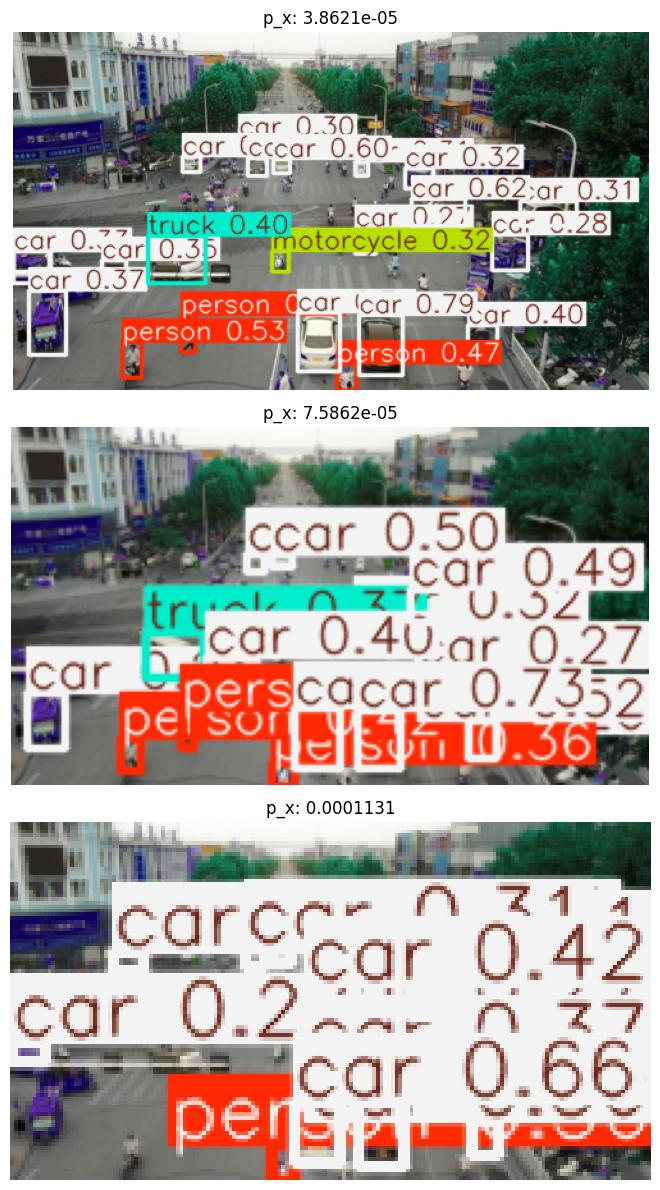

In [18]:
# Resolution Augmentation Evaluation
res_perturbed_metrics = []
_, ax = plt.subplots(len(VISUALIZATION_INDICES), figsize=(30, 12))
for idx, a in enumerate(resolution_augmentations):
    # reset the metric object for each dataset
    mAP_metric.reset()
    result, _, _ = evaluate(model=yolo_model, dataset=single_image_dataset, augmentation=a, metric=mAP_metric)
    res_perturbed_metrics.append(result)

    if idx in VISUALIZATION_INDICES:
        # quickest way is to re-evaluate
        print(f"Perturbation #{idx}: p_x value {a.augment.sensor.p_x:0.5}")
        datum = single_image_dataset[0]
        batch = ([datum[0]], [datum[1]], [datum[2]])
        # Extract the image from the augmentation and switch it to channel last
        aug = np.transpose(a(batch)[0][0], (1, 2, 0))
        # Plot image
        ax_idx = VISUALIZATION_INDICES.index(idx)
        ax[ax_idx].imshow(model(aug)[0].plot())
        ax[ax_idx].set_title(f"p_x: {a.augment.sensor.p_x:0.5}")
        _ = ax[ax_idx].axis("off")
plt.tight_layout()

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

100%|██████████| 1/1 [00:01<00:00,  1.73s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

100%|██████████| 1/1 [00:01<00:00,  1.80s/it]

Perturbation #3: bit depth value 4


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

100%|██████████| 1/1 [00:01<00:00,  1.83s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

100%|██████████| 1/1 [00:01<00:00,  1.72s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

100%|██████████| 1/1 [00:01<00:00,  1.74s/it]

Perturbation #9: bit depth value 10


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

100%|██████████| 1/1 [00:01<00:00,  1.75s/it]

Perturbation #15: bit depth value 16


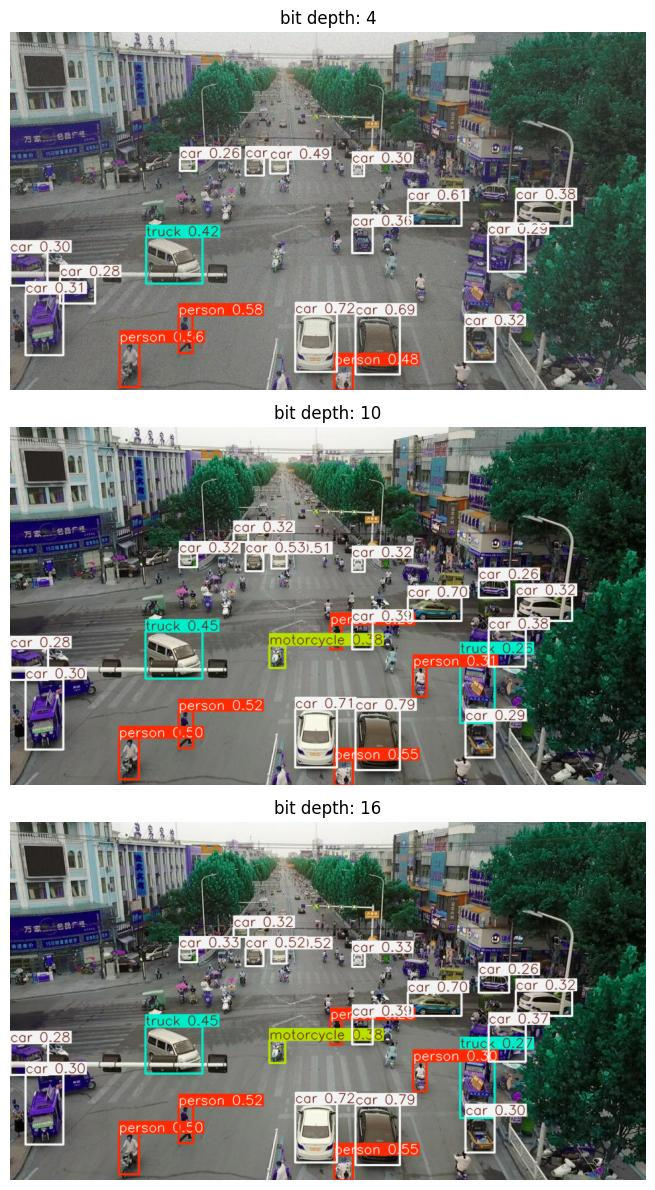

In [19]:
# Noise Augmentation Perturbation

noise_perturbed_metrics = []
_, ax = plt.subplots(len(VISUALIZATION_INDICES), figsize=(30, 12))
for idx, a in enumerate(noise_augmentations):
    # reset the metric object for each dataset
    mAP_metric.reset()
    result, _, _ = evaluate(model=yolo_model, dataset=single_image_dataset, augmentation=a, metric=mAP_metric)
    noise_perturbed_metrics.append(result)

    if idx in VISUALIZATION_INDICES:
        # quickest way is to re-evaluate
        print(f"Perturbation #{idx}: bit depth value {a.augment.sensor.bit_depth}")
        datum = single_image_dataset[0]
        batch = ([datum[0]], [datum[1]], [datum[2]])
        # Extract the image from the augmentation and switch it to channel last
        aug = np.transpose(a(batch)[0][0], (1, 2, 0))
        # Plot image
        ax_idx = VISUALIZATION_INDICES.index(idx)
        ax[ax_idx].imshow(model(aug)[0].plot())
        ax[ax_idx].set_title(f"bit depth: {a.augment.sensor.bit_depth}")
        _ = ax[ax_idx].axis("off")
plt.tight_layout()

## Evaluation Analysis

Now we can plot how the metrics (for example, mAP @ IoU=50) vary with perturbation level, keeping in mind this is the mAP scores compared against the detections in the unperturbed image.

### Resolution-focused Sensor Transformation Analysis

We will start by analysing the resolution focused sensor transformation.

30


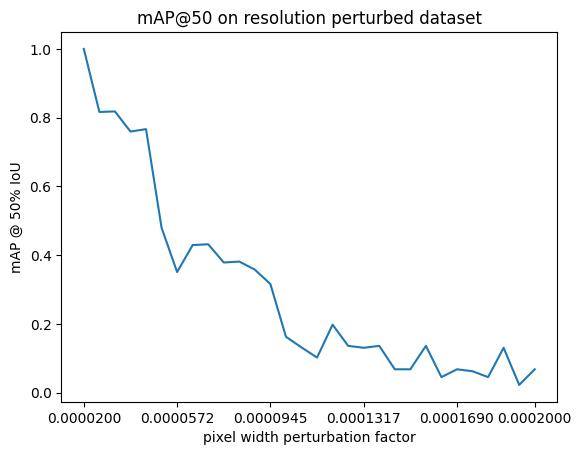

In [20]:
map50_list = [m["map_50"].item() for m in res_perturbed_metrics]
print(len(resolution_perturbation_values))
plt.title("mAP@50 on resolution perturbed dataset")
plt.xlabel("pixel width perturbation factor")
plt.ylabel("mAP @ 50% IoU")
plt.xticks(
    [j for i, j in enumerate(resolution_perturbation_values) if not i % 6] + [resolution_perturbation_values[-1]],
)
_ = plt.plot(resolution_perturbation_values, map50_list)

### Evaluation Interpretation

**General things to know about mAP calculation**:
- The mAP metric calculation does not take into account the images that do not have any detection or any ground truth. In such cases, it returns the default initialization value, -1. It means it couldn't compute the metric. (Source: [link](https://github.com/Lightning-AI/torchmetrics/issues/1184#issuecomment-1589210748)). Hence, in this notebook example, we clip values to a range of `[0, 1]`.
- When having images with no ground truth, the order of those images in the batch can change the mAP calculation. To be more precise, if empty images are at the end of the batch, they will be ignored in the computation. But the empty images that are placed before the last non-empty image are taken into account. (Source: [link](https://github.com/Lightning-AI/torchmetrics/issues/1774#issuecomment-1590681234)).


The metric shown, mAP@50, is the average precision of detections across all classes when the bounding box IoU is at least 0.5 (for more details, [see here](https://lightning.ai/docs/torchmetrics/stable/detection/mean_average_precision.html)). In general, we observe a general decreasing trend in mAP as the pixel width perturbation factor increases (Note the mAP is guaranteed to be 1.0 when the perturbation is 0, i.e. when the image is unchanged, the two detection sets are identical.)

#### Additional Plots

For further insight, we can plot the mAP per class:

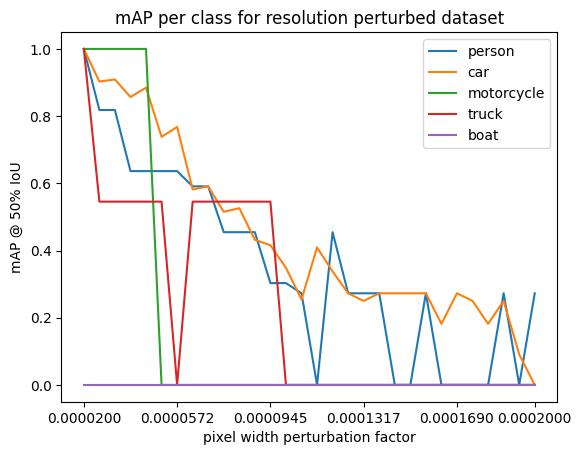

In [21]:
#
# Each instance of the metrics object has, potentially, a different set of observed classes.
# Loop through them to accumulate a unified set of classes to ensure consistent plotting across
# all thresholds.
#

unified_classes = set()
for m in res_perturbed_metrics:
    for class_idx in m["classes"].tolist():
        unified_classes.add(class_idx)

#
# dictionary of class_idx -> list of per-class mAP, or 0 if not present at that threshold
#

class_mAP = {class_idx: [] for class_idx in unified_classes}  # noqa: N816

#
# populate the lists across the perturbation values
#

for m in res_perturbed_metrics:
    this_perturbation_classes = m["classes"].tolist()
    for class_idx in unified_classes:
        if class_idx in this_perturbation_classes:
            # the index of the class in this individual metric instance
            this_class_idx = this_perturbation_classes.index(class_idx)
            class_map_value = m["map_per_class"][this_class_idx].item()
            # Clip value to 0 if negative
            if class_map_value < 0:
                class_mAP[class_idx].append(0)
            else:
                class_mAP[class_idx].append(m["map_per_class"][this_class_idx].item())
        else:
            class_mAP[class_idx].append(0)

#
# plot
#

plt.title("mAP per class for resolution perturbed dataset")
plt.xlabel("pixel width perturbation factor")
plt.ylabel("mAP @ 50% IoU")
plt.xticks(
    [j for i, j in enumerate(resolution_perturbation_values) if not i % 6] + [resolution_perturbation_values[-1]],
)
for class_idx, class_mAP_list in class_mAP.items():  # noqa: N816
    plt.plot(resolution_perturbation_values, class_mAP_list, label=baseline[0].names[class_idx])
plt.legend()
plt.show()

This plot shows several interesting results:

- The only "false alarm" **class** (with a mAP value of 0) is the appearance of bus and traffic light detections that occur when the pixel width size has gotten much larger than the original value. There are no buses or traffic light detections in the "ground truth" unperturbed detections (but again, since our "ground truth" is based on the detections from the unperturbed image, this does not necessarily mean there are no true buses or traffic lights in the image.)

- motorcycles are slightly more robust to small changes in the pixel size, but quickly fall off entirely

- person and car detections are relatively robust with person detections maintaining an mAP of ~0.5 almost all the way through the perturbation range. This could be for a number of reasons:

    - The non-car classes detected in the unperturbed image are all in the foreground, and are thus larger. Thus when the resolution decreases, they remain visible the longest.

Any conclusions about classification accuracy should be considered in light of these caveats. In particular, the foreground positioning of the detected non-car objects suggests that instead of looking at per-class results, we drill down by bounding box area. Fortunately, the metrics class supports this:


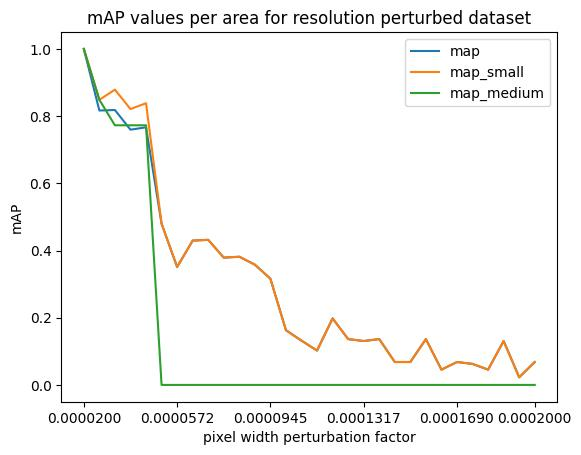

In [22]:
plt.title("mAP values per area for resolution perturbed dataset")
plt.xlabel("pixel width perturbation factor")
plt.ylabel("mAP")
plt.xticks(
    [j for i, j in enumerate(resolution_perturbation_values) if not i % 6] + [resolution_perturbation_values[-1]],
)
for k in ("map", "map_small", "map_medium"):
    plt.plot(
        resolution_perturbation_values,
        # Clip values to 0 if negative
        [m[k].item() if m[k].item() >= 0 else 0 for m in res_perturbed_metrics],
        label=k,
    )
plt.legend()
plt.show()

The `map` line covers all sizes; `map_small` and `map_medium` are the mean average precision for objects (smaller than 32^2 pixels, between 32^2 and 96^2 pixels) in area, respectively. (There are no detections in the `map_large` category.) Here, the mAP value is averaged over a **range** of IoU thresholds, between 0.5 and 0.95. We see that medium objects, quickly go from accurate to false positive detections while the small targets have a steady decline in mAP. The false positive values for the medium targets could be due to the fact that the medium targets become the size of small targets and get confused with the original small target distribution while the small targets do not move into any other categories original distribution.


### Noise-focused Sensor Tranformation Analysis

Now we will analyse the noise focused sensor transformation that perturbs the bit depth parameter

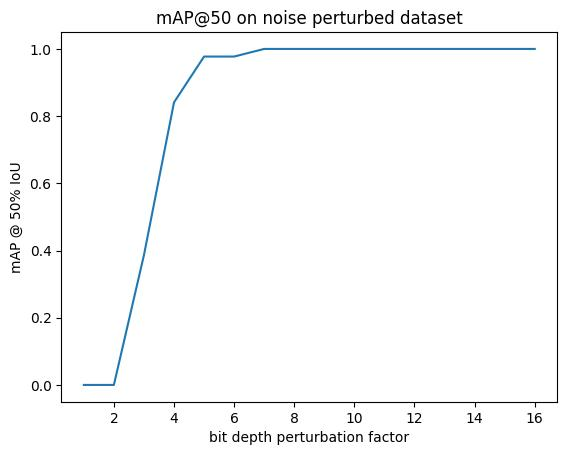

In [23]:
map50_list = [m["map_50"].item() for m in noise_perturbed_metrics]
plt.title("mAP@50 on noise perturbed dataset")
plt.xlabel("bit depth perturbation factor")
plt.ylabel("mAP @ 50% IoU")
_ = plt.plot(noise_perturbation_values, map50_list)

#### Evaluation Interpretation

When The bit depth is extremely low with less than 9-10 bits, there is significant performance drop, but after 9-10 bits, the performance holds steady at one. This is due sto the fact that once the necessary bit depth is reached, all higher bit depth values are guaranteed to be able to adequately represent the values of the pixels.

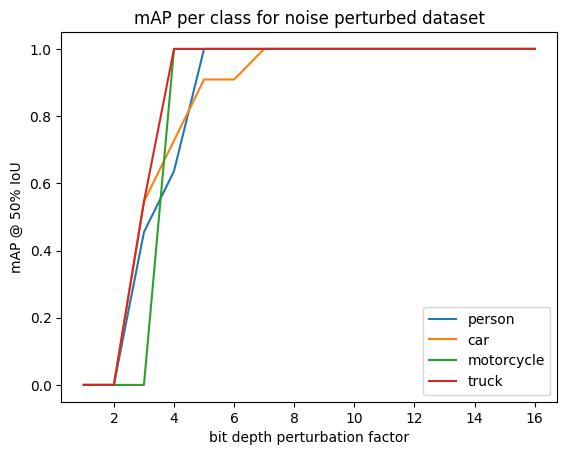

In [24]:
#
# Each instance of the metrics object has, potentially, a different set of observed classes.
# Loop through them to accumulate a unified set of classes to ensure consistent plotting across
# all thresholds.
#

unified_classes = set()
for m in noise_perturbed_metrics:
    for class_idx in m["classes"].tolist():
        unified_classes.add(class_idx)

#
# dictionary of class_idx -> list of per-class mAP, or 0 if not present at that threshold
#

class_mAP = {class_idx: [] for class_idx in unified_classes}  # noqa: N816

#
# populate the lists across the perturbation values
#

for m in noise_perturbed_metrics:
    this_perturbation_classes = m["classes"].tolist()
    for class_idx in unified_classes:
        if class_idx in this_perturbation_classes:
            # the index of the class in this individual metric instance
            this_class_idx = this_perturbation_classes.index(class_idx)
            class_map_value = m["map_per_class"][this_class_idx].item()
            # Clip value to 0 if negative
            if class_map_value < 0:
                class_mAP[class_idx].append(0)
            else:
                class_mAP[class_idx].append(m["map_per_class"][this_class_idx].item())
        else:
            class_mAP[class_idx].append(0)

#
# plot
#

plt.title("mAP per class for noise perturbed dataset")
plt.xlabel("bit depth perturbation factor")
plt.ylabel("mAP @ 50% IoU")
for class_idx, class_mAP_list in class_mAP.items():  # noqa: N816
    plt.plot(noise_perturbation_values, class_mAP_list, label=baseline[0].names[class_idx])
plt.legend()
plt.show()

We see here that the car class is the least resilient to change in the bit depth as it takes the highest value to achieve perfect mAP.

Interestingly when the bit depth is ~3, the model incorrectly attributes one of the detections to the boat class.

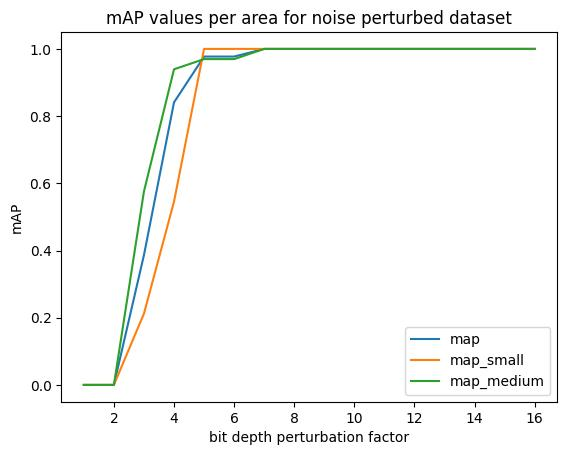

In [25]:
plt.title("mAP values per area for noise perturbed dataset")
plt.xlabel("bit depth perturbation factor")
plt.ylabel("mAP")
for k in ("map", "map_small", "map_medium"):
    plt.plot(noise_perturbation_values, [m[k].item() for m in noise_perturbed_metrics], label=k)
plt.legend()
plt.show()

This final comparison shows that medium and small detections respond similarly to the perturbations in bit depth. There are no large detections in the original set of detections, so it is not unexpected that there are no large objects in the graph.

## End of Notebook